In [1]:
train_path = '../../datasets/santander_customer_transaction_prediction/train.csv'
test_path = '../../datasets/santander_customer_transaction_prediction/test.csv'

In [2]:
%load_ext autoreload
%autoreload 2

# Divide los fake de los reales

In [3]:
# LOAD LIBRARIES
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd, numpy as np, gc
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import statsmodels.api as sm

# GET INDICIES OF REAL TEST DATA FOR FE
#######################
# TAKE FROM YAG320'S KERNEL
# https://www.kaggle.com/yag320/list-of-fake-samples-and-public-private-lb-split

train_path = '../../datasets/santander_customer_transaction_prediction/train.csv'
test_path = '../../datasets/santander_customer_transaction_prediction/test.csv'

df_test = pd.read_csv(test_path)
df_test.drop(['ID_code'], axis=1, inplace=True)
df_test = df_test.values

unique_samples = []
unique_count = np.zeros_like(df_test)
for feature in range(df_test.shape[1]):
    _, index_, count_ = np.unique(df_test[:, feature], return_counts=True, return_index=True)
    unique_count[index_[count_ == 1], feature] += 1

# Samples which have unique values are real the others are fake
real_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
synthetic_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]

print('Found',len(real_samples_indexes),'real test')
print('Found',len(synthetic_samples_indexes),'fake test')

###################

d = {}
for i in range(200): d['var_'+str(i)] = 'float32'
d['target'] = 'uint8'
d['ID_code'] = 'object'

train = pd.read_csv(train_path, dtype=d)
test = pd.read_csv(test_path, dtype=d)

print('Loaded',len(train),'rows of train')
print('Loaded',len(test),'rows of test')

Found 100000 real test
Found 100000 fake test
Loaded 200000 rows of train
Loaded 200000 rows of test


# Agrega columna con features count

In [4]:
# FREQUENCY ENCODE
def encode_FE(df,col,test):
    cv = df[col].value_counts()
    nm = col+'_FE'
    df[nm] = df[col].map(cv)
    test[nm] = test[col].map(cv)
    test[nm].fillna(0,inplace=True)
    if cv.max()<=255:
        df[nm] = df[nm].astype('uint8')
        test[nm] = test[nm].astype('uint8')
    else:
        df[nm] = df[nm].astype('uint16')
        test[nm] = test[nm].astype('uint16')        
    return

test['target'] = -1
comb = pd.concat([train,test.loc[real_samples_indexes]],axis=0,sort=True)
for i in range(200): 
    encode_FE(comb,'var_'+str(i),test)
train = comb[:len(train)]; del comb
print('Added 200 new magic features!')

Added 200 new magic features!


In [5]:
# train.to_csv('train_with_counts.csv', index=False)

In [6]:
# test.to_csv('test_with_counts.csv', index=False)

In [7]:
# Funcion que devuelve grid para graficar resultado de LGBM
def get_df_grid(train, var_idx):
    var_i = 'var_' + str(var_idx)
    mn,mx = train[var_i].min(), train[var_i].max()
    mnFE = train[var_i+'_FE'].min()
    mxFE = train[var_i+'_FE'].max()
    step = 50
    stepB = mxFE - mnFE + 1
    w = (mx-mn)/step
    x = w * (np.arange(0,step)+0.5) + mn
    x2 = np.array([])
    for i in range(stepB):
        x2 = np.concatenate([x,x2])
    # 
    df_grid = pd.DataFrame({var_i:x2})
    df_grid[var_i+'_FE'] = mnFE + (mxFE-mnFE)/(stepB-1) * (df_grid.index//step)
    df_grid['pred'] = 0
    return df_grid

In [8]:
param = {
    'learning_rate': 0.04,
    'num_leaves': 3,
    'metric':'auc',
    'boost_from_average':'false',
    'feature_fraction': 1.0,
    'max_depth': -1,
    'objective': 'binary',
    'verbosity': -10}

evals_result = {}
oof = np.zeros(len(train))
preds = np.zeros(len(test))

In [9]:
train_shuffled = train.sample(frac=1,random_state=42)

In [10]:
# np.save('indexes_shuffled', train_shuffled.index.values)

In [11]:
# Entrena una variable (var_idx)
def train_var(train_shuffled, test, var_idx, return_model=False):
    # 5-FOLD WITH MAGIC
    var_i = 'var_' + str(var_idx)
    features = [var_i, var_i+'_FE']
    oof = np.zeros(len(train_shuffled))
    test_preds = np.zeros(len(test))
    df_grid = get_df_grid(train_shuffled, var_idx)
    for k in range(5):
        valid = train_shuffled.iloc[k*40000:(k+1)*40000]
        train = train_shuffled[~train_shuffled.index.isin(valid.index) ]    
        trn_data  = lgb.Dataset(train[features], label=train['target'])
        val_data = lgb.Dataset(valid[features], label=valid['target'])     
        model = lgb.train(param, trn_data, 750, valid_sets = [trn_data, val_data], 
                verbose_eval=False, evals_result=evals_result)      
        x = evals_result['valid_1']['auc']
        best = x.index(max(x))
        print('k=',k,'best=',best, end= ' / ')
        oof[k*40000:(k+1)*40000] = model.predict(valid[features], num_iteration=best)
        test_preds += model.predict(test[features], num_iteration=best)/5.0
        df_grid['pred'] += model.predict(df_grid[features], num_iteration=best)/5.0
    val_auc = roc_auc_score(train_shuffled['target'], oof)
    print()
    print('VAR_'+str(var_i)+' with magic val_auc =',round(val_auc,5))
    if return_model:
        return test_preds, oof, df_grid, model
    return test_preds, oof, df_grid

In [52]:
test_preds, oof, df_grid, model = train_var(train_shuffled, test, 198, True)

k= 0 best= 243 / k= 1 best= 168 / k= 2 best= 602 / k= 3 best= 260 / k= 4 best= 315 / 
VAR_var_198 with magic val_auc = 0.55088


In [68]:
from IPython.display import Image, display

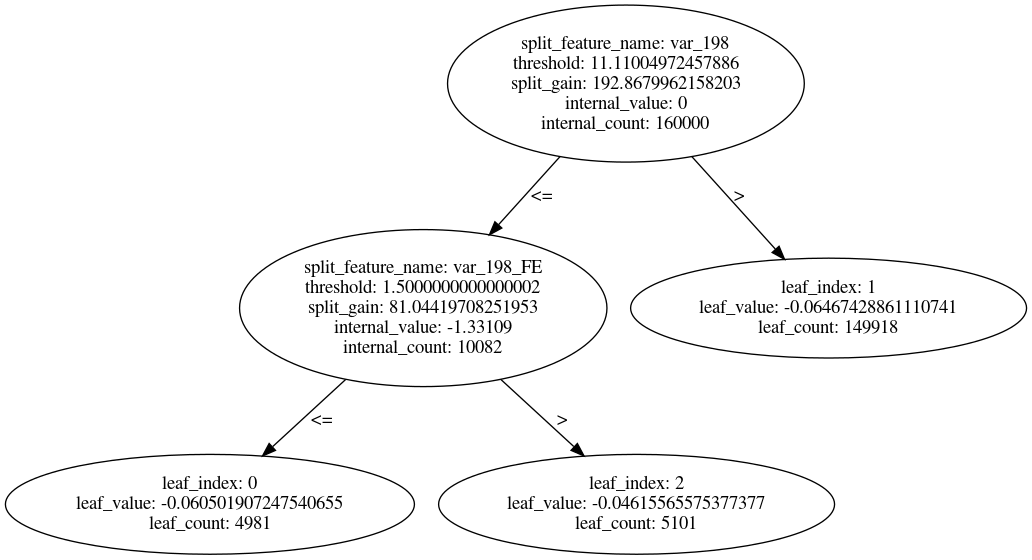

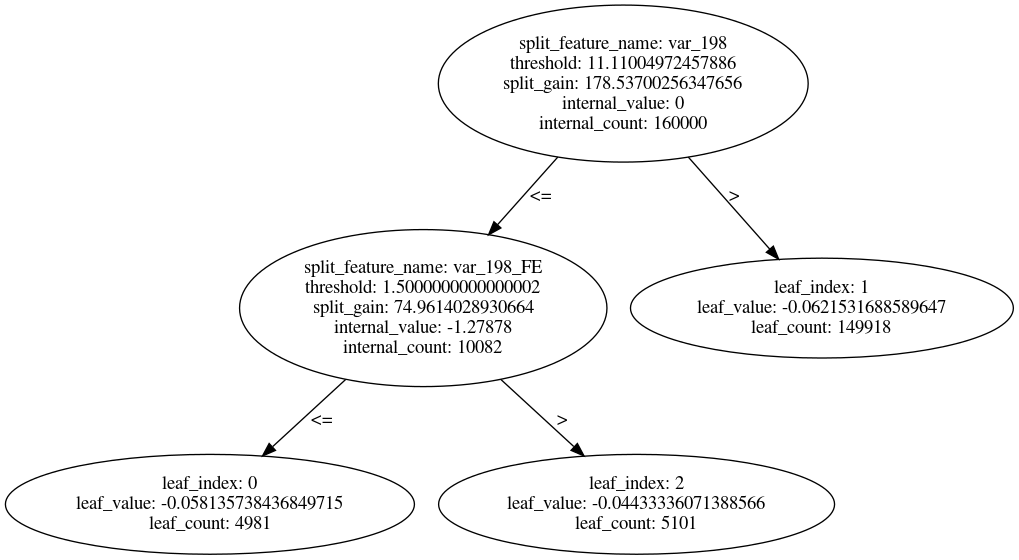

In [78]:
for i in range(2): #750 es el maximo. Cantidad de arboles que boostea
    graph = lgb.plotting.create_tree_digraph(model, tree_index=i,
                                             old_format='png', 
                                             show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'])
    display(Image(graph.render()))
    plt.show()

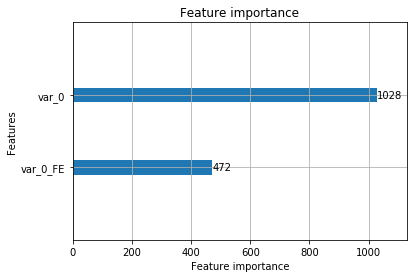

In [20]:
lgb.plotting.plot_importance(model)

# Entreno 200 variables

In [40]:
num_vars = 200
# SAVE OUT-OF-FOLD PREDICTIONS
all_oof = np.zeros((len(train_shuffled),num_vars))

# SAVE TEST PREDICTIONS
all_test_preds = np.zeros((len(test),num_vars))

for i in range(num_vars):
    test_preds, oof, df_grid = train_var(train_shuffled, test, i)
    all_oof[:, i] = oof
    all_test_preds[:, i] = test_preds

k= 0 best= 108 / k= 1 best= 177 / k= 2 best= 745 / k= 3 best= 591 / k= 4 best= 191 / 
VAR_var_0 with magic val_auc = 0.54785
k= 0 best= 252 / k= 1 best= 92 / k= 2 best= 730 / k= 3 best= 201 / k= 4 best= 294 / 
VAR_var_1 with magic val_auc = 0.54527
k= 0 best= 200 / k= 1 best= 129 / k= 2 best= 302 / k= 3 best= 529 / k= 4 best= 215 / 
VAR_var_2 with magic val_auc = 0.55076
k= 0 best= 6 / k= 1 best= 55 / k= 2 best= 124 / k= 3 best= 118 / k= 4 best= 59 / 
VAR_var_3 with magic val_auc = 0.50724
k= 0 best= 88 / k= 1 best= 58 / k= 2 best= 512 / k= 3 best= 237 / k= 4 best= 60 / 
VAR_var_4 with magic val_auc = 0.50604
k= 0 best= 710 / k= 1 best= 97 / k= 2 best= 69 / k= 3 best= 105 / k= 4 best= 385 / 
VAR_var_5 with magic val_auc = 0.5208
k= 0 best= 80 / k= 1 best= 34 / k= 2 best= 61 / k= 3 best= 204 / k= 4 best= 745 / 
VAR_var_6 with magic val_auc = 0.5388
k= 0 best= 47 / k= 1 best= 445 / k= 2 best= 27 / k= 3 best= 190 / k= 4 best= 725 / 
VAR_var_7 with magic val_auc = 0.50199
k= 0 best= 92 / k

In [ ]:
roc_auc_score(train_shuffled['target'], all_oof.sum(axis=1)/200)

# Guardo data entrenada

In [41]:
# np.save('all_oof', all_oof)
# np.save('all_test_preds', all_test_preds)

NameError: name 'roc_auc_score' is not defined

In [113]:
all_oof_intercept = np.append(all_oof, np.ones((200000,1)), axis=1)

In [114]:
all_oof_intercept.shape

(200000, 201)

In [261]:
train_shuffled['target'].shape

(200000,)

In [250]:
# ENSEMBLE MODEL WITH MAGIC
logr = sm.Logit(train_shuffled['target'], all_oof_intercept)
%time logr = logr.fit(disp=1, method='newton')
ensemble_preds = logr.predict(all_oof_intercept)
ensemble_auc = roc_auc_score(train_shuffled['target'], ensemble_preds)  
print('##################')
print('Combined Model with magic Val_AUC=',round(ensemble_auc,5))
print()

Optimization terminated successfully.
         Current function value: 0.180549
         Iterations 9
CPU times: user 11.9 s, sys: 716 ms, total: 12.6 s
Wall time: 2.1 s
##################
Combined Model with magic Val_AUC= 0.92011



In [238]:
from sklearn.linear_model import LogisticRegression

In [239]:
all_oof_norm = (all_oof - all_oof.mean(axis=0))/all_oof.std(axis=0)

In [240]:
all_oof_norm.shape

(200000, 200)

In [228]:
all_oof_intercept_norm = np.append(all_oof_norm, np.ones((200000,1)), axis=1)
all_oof_intercept_norm.shape

(200000, 201)

In [229]:
all_oof_norm[:,0].mean(), all_oof_norm[:,0].std()

(-8.730486911190382e-13, 0.9999999999997735)

In [264]:
model = LogisticRegression(C=1e15, solver='newton-cg', fit_intercept=False)
model.fit(all_oof_intercept_norm, train_shuffled['target'])
ensemble_preds_sk = model.predict_proba(all_oof_intercept_norm)[:, 1]

In [265]:
ensemble_auc = roc_auc_score(train_shuffled['target'], ensemble_preds_sk)  
print('##################')
print('Combined Model with magic Val_AUC=',round(ensemble_auc,5))
print()

##################
Combined Model with magic Val_AUC= 0.92011



In [30]:
x = df_grid['pred'].values
x = np.reshape(x,(stepB,step))
x = np.flip(x,axis=0)

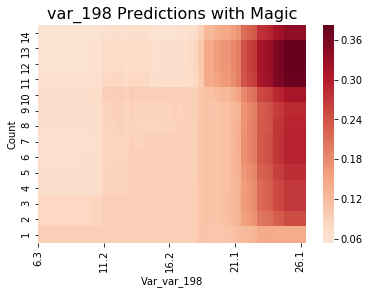

In [31]:
sns.heatmap(x, cmap='RdBu_r', center=0.0) 
plt.title(var_i+' Predictions with Magic',fontsize=16)    
plt.xticks(np.linspace(0,49,5),np.round(np.linspace(mn,mx,5),1))
plt.xlabel('Var_'+str(var_i))
s = min(mxFE-mnFE+1,20)
plt.yticks(np.linspace(mnFE,mxFE,s)-0.5,np.linspace(mxFE,mnFE,s).astype('int'))
plt.ylabel('Count')
plt.show()